In [25]:
import numpy as np
import glob
import re
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
# python -m spacy download en_core_web_sm
#nltk stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#pandas
import pandas as pd

#vis
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

[nltk_data] Downloading package stopwords to /home/lennarth/Documents/
[nltk_data]     GitHub/nlp_project/venv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
df = pd.read_csv("../../data/ExtractedTweets.csv")
df.head()

# separate dataframes for both parties
df_dem = df.query("Party == 'Democrat'")
df_rep = df.query("Party == 'Republican'")

### Extract tweet information

In [27]:
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

# make new columns for retweeted usernames, mentioned usernames and hashtags
df_dem['retweeted'] = df_dem['Tweet'].apply(find_retweeted)
df_dem['mentioned'] = df_dem['Tweet'].apply(find_mentioned)
df_dem['hashtags'] = df_dem['Tweet'].apply(find_hashtags)

df_rep['retweeted'] = df_rep['Tweet'].apply(find_retweeted)
df_rep['mentioned'] = df_rep['Tweet'].apply(find_mentioned)
df_rep['hashtags'] = df_rep['Tweet'].apply(find_hashtags)

print("Extracted tweet metadata")

/tmp/ipykernel_22294/1609610417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dem['retweeted'] = df_dem['Tweet'].apply(find_retweeted)
/tmp/ipykernel_22294/1609610417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dem['mentioned'] = df_dem['Tweet'].apply(find_mentioned)
/tmp/ipykernel_22294/1609610417.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Extracted tweet metadata


/tmp/ipykernel_22294/1609610417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rep['mentioned'] = df_rep['Tweet'].apply(find_mentioned)
/tmp/ipykernel_22294/1609610417.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rep['hashtags'] = df_rep['Tweet'].apply(find_hashtags)


### Clean metioned, retweets and hashtags from tweet

In [28]:
stop_words = stopwords.words('english')
stop_words.append("rt")

def clean_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.sub('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.sub('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean(tweet):
    # Remove mentions, retweets and hashtags
    tweet = clean_hashtags(tweet)
    tweet = clean_mentioned(tweet)
    tweet = clean_retweeted(tweet)
    tweet = tweet.lower()
    # Remove punctuation
    tweet = re.sub("[\\.,;:!/\\?]*", "", tweet)
    # Remove links
    tweet = re.sub(r"http\S+", "", tweet)
    # Remove stop words
    tweet = ' '.join([word for word in tweet.split(' ') if not word in stop_words])
    # Remove multiple spaces
    tweet = re.sub("\\s+", " ", tweet)
    return tweet

df_dem['TweetCleaned'] = df['Tweet'].apply(clean)
df_rep['TweetCleaned'] = df_rep['Tweet'].apply(clean)

print("Cleaned tweets")

/tmp/ipykernel_22294/3562703517.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dem['TweetCleaned'] = df['Tweet'].apply(clean)


Cleaned tweets


/tmp/ipykernel_22294/3562703517.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rep['TweetCleaned'] = df_rep['Tweet'].apply(clean)


### Lemmatize the text

In [29]:
import warnings
# Ignore DeprecationWarning from SelectableGroups
warnings.filterwarnings("ignore", category=DeprecationWarning)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatization(tweet, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    doc = nlp(tweet)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    return final

df_dem['TweetCleaned'] = df_dem['TweetCleaned'].apply(lemmatization)
df_rep['TweetCleaned'] = df_rep['TweetCleaned'].apply(lemmatization)

print("Lemmatized tweets")

/tmp/ipykernel_22294/1212916713.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dem['TweetCleaned'] = df_dem['TweetCleaned'].apply(lemmatization)


Lemmatized tweets


/tmp/ipykernel_22294/1212916713.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rep['TweetCleaned'] = df_rep['TweetCleaned'].apply(lemmatization)


In [30]:
def gen_words(tweet):
    # Use gensims simple_preprocess to remove accents, lowercase and tokenize
    return gensim.utils.simple_preprocess(tweet, deacc=True)

df_dem['TweetWords'] = df_dem['TweetCleaned'].apply(gen_words)
df_rep['TweetWords'] = df_rep['TweetCleaned'].apply(gen_words)

print("Generated tokens")

/tmp/ipykernel_22294/1176265339.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dem['TweetWords'] = df_dem['TweetCleaned'].apply(gen_words)


Generated tokens


/tmp/ipykernel_22294/1176265339.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rep['TweetWords'] = df_rep['TweetCleaned'].apply(gen_words)


In [31]:
# BIGRAMS AND TRIGRAMS
# DEM
bigram_phrases_dem = gensim.models.Phrases(df_dem['TweetWords'], min_count=5, threshold=100)
trigram_phrases_dem = gensim.models.Phrases(bigram_phrases_dem[df_dem['TweetWords']], threshold=100)

bigram_dem = gensim.models.phrases.Phraser(bigram_phrases_dem)
trigram_dem = gensim.models.phrases.Phraser(trigram_phrases_dem)

# REP
bigram_phrases_rep = gensim.models.Phrases(df_rep['TweetWords'], min_count=5, threshold=100)
trigram_phrases_rep = gensim.models.Phrases(bigram_phrases_rep[df_rep['TweetWords']], threshold=100)

bigram_rep = gensim.models.phrases.Phraser(bigram_phrases_rep)
trigram_rep = gensim.models.phrases.Phraser(trigram_phrases_rep)

def make_bigrams_dem(tweetWords):
    return bigram_dem[tweetWords]

def make_trigrams_dem(bigrams):
    return trigram_dem[bigram_dem[bigrams]]

def make_bigrams_rep(tweetWords):
    return bigram_rep[tweetWords]

def make_trigrams_rep(bigrams):
    return trigram_rep[bigram_rep[bigrams]]


df_dem['bigramms'] =  df_dem['TweetWords'].apply(make_bigrams_dem)
df_dem['trigrams'] = df_dem['bigramms'].apply(make_trigrams_dem)

df_rep['bigramms'] =  df_rep['TweetWords'].apply(make_bigrams_rep)
df_rep['trigrams'] = df_rep['bigramms'].apply(make_trigrams_rep)


print("Generated trigrams")

/tmp/ipykernel_22294/4045213363.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dem['bigramms'] =  df_dem['TweetWords'].apply(make_bigrams_dem)
/tmp/ipykernel_22294/4045213363.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dem['trigrams'] = df_dem['bigramms'].apply(make_trigrams_dem)
/tmp/ipykernel_22294/4045213363.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

Generated trigrams


/tmp/ipykernel_22294/4045213363.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rep['trigrams'] = df_rep['bigramms'].apply(make_trigrams_rep)


In [32]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

# DEM
id2word_dem = corpora.Dictionary(df_dem['trigrams'])
texts_dem = df_dem['trigrams']
corpus_dem = [id2word_dem.doc2bow(text) for text in texts_dem]


tfidf = TfidfModel(corpus_dem, id2word=id2word_dem)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus_dem)):
    bow = corpus_dem[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word_dem[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus_dem[i] = new_bow

# REP
id2word_rep = corpora.Dictionary(df_rep['trigrams'])
texts_rep = df_rep['trigrams']
corpus_rep = [id2word_rep.doc2bow(text) for text in texts_rep]


tfidf = TfidfModel(corpus_rep, id2word=id2word_rep)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus_rep)):
    bow = corpus_rep[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word_rep[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus_rep[i] = new_bow

print("TF-IDF removal")
print("Finish preprocessing")

TF-IDF removal
Finish preprocessing


In [33]:
# import pickle
# file = open("data.bin", "wb")
# pickle.dump((df, id2word, corpus, tfidf), file)
#

In [34]:
# import pickle
# (df, id2word, corpus, tfidf) = pickle.load(open("data.bin", "rb"))
# df.head()
# texts = df['trigrams']

In [35]:
lda_model_dem = gensim.models.LdaMulticore(
                corpus=corpus_dem[:-1],
                id2word=id2word_dem,
                num_topics=10,
                random_state=100,
                chunksize=100,
                passes=10
            )

lda_model_rep = gensim.models.LdaMulticore(
                corpus=corpus_rep[:-1],
                id2word=id2word_rep,
                num_topics=10,
                random_state=100,
                chunksize=100,
                passes=10
            )


In [36]:
vis = pyLDAvis.gensim_models.prepare(lda_model_dem, corpus_dem, id2word_dem, mds="mmds", R=30)
vis

/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWar

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.303340  0.241335       1        1  11.857265
8      0.099052  0.301182       2        1  11.418076
1     -0.103312 -0.069503       3        1  11.290794
5     -0.137566  0.349358       4        1  10.806936
2      0.109133 -0.357950       5        1  10.080285
7     -0.298396  0.158381       6        1   9.823566
9     -0.184354 -0.366377       7        1   9.698565
0     -0.403117 -0.097725       8        1   9.153886
4      0.198606 -0.095564       9        1   7.968456
6      0.416615 -0.063137      10        1   7.902172, topic_info=          Term         Freq        Total Category  logprob  loglift
23       thank  2529.000000  2529.000000  Default  30.0000  30.0000
122    student  1589.000000  1589.000000  Default  29.0000  29.0000
359      woman  1410.000000  1410.000000  Default  28.0000  28.0000
54        join  1842.000000  1842.000000  Default  27.0000  27.0000
603        tax  1061.000000  1061.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
249        let   203.644384   659.676805  Topic10  -4.7394   1.3627
277         go   222.468938   897.152946  Topic10  -4.6510   1.1436
174  colleague   199.046393   639.223465  Topic10  -4.7622   1.3713
166      honor   222.479979  1076.031950  Topic10  -4.6509   0.9618
435       pass   161.302269   732.884140  Topic10  -4.9725   1.0243

[578 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
732       5  0.991204  ability
2635      7  0.989737    abuse
112       5  0.998508   access
306       4  0.747399      act
306       8  0.252135      act
...     ...       ...      ...
63        4  0.255647     year
63        5  0.123515     year
63        8  0.049406     year
63        9  0.054576     year
63       10  0.069513     year

[975 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 9, 2, 6, 3, 8, 10, 1, 5, 7])

In [37]:
vis = pyLDAvis.gensim_models.prepare(lda_model_rep, corpus_rep, id2word_rep, mds="mmds", R=30)
vis

/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__versio

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.254769  0.222061       1        1  11.474723
6      0.090769  0.329875       2        1  11.188436
3     -0.268993 -0.267952       3        1  10.865802
5     -0.192513  0.373158       4        1  10.669822
0     -0.007879 -0.378169       5        1  10.552472
2     -0.191757  0.115923       6        1  10.274536
7      0.033588 -0.115202       7        1   9.800112
8     -0.420958 -0.017942       8        1   9.011580
1      0.328370 -0.269124       9        1   8.357659
4      0.374605  0.007374      10        1   7.804858, topic_info=        Term         Freq        Total Category  logprob  loglift
288      tax  2406.000000  2406.000000  Default  30.0000  30.0000
0       bill  1917.000000  1917.000000  Default  29.0000  29.0000
79      join  1758.000000  1758.000000  Default  28.0000  28.0000
195     live  1451.000000  1451.000000  Default  27.0000  27.0000
179  support  1397.000000  1397.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
113      get   161.859034  1098.478843  Topic10  -4.9958   0.6355
335     work   171.874236  2155.234382  Topic10  -4.9358   0.0215
350     come   149.613793   764.431407  Topic10  -5.0745   0.9193
283     need   143.080798   982.849604  Topic10  -5.1191   0.6234
131    house   138.812763  1041.880417  Topic10  -5.1494   0.5348

[566 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
946       8  0.992165           abuse
1363      1  0.992094         academy
479       4  0.994399          access
3003      3  0.992586  accountability
264       3  0.612011             act
...     ...       ...             ...
135       4  0.105706       yesterday
135       7  0.063424       yesterday
135       9  0.132485       yesterday
1012      5  0.789272           young
1012      8  0.209581           young

[933 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 4, 6, 1, 3, 8, 9, 2, 5])

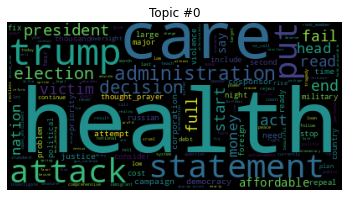

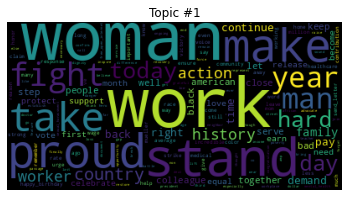

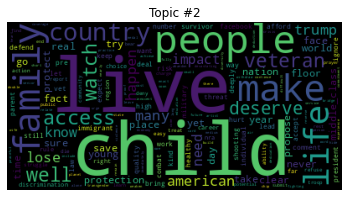

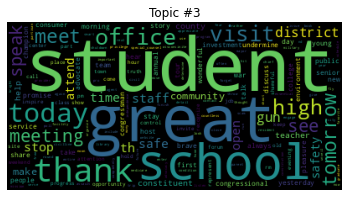

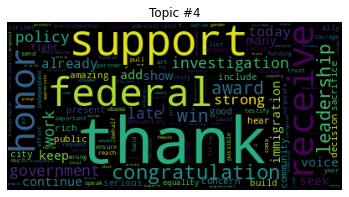

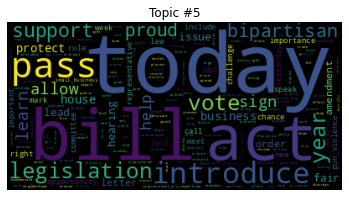

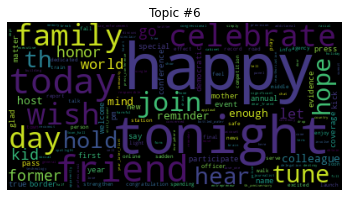

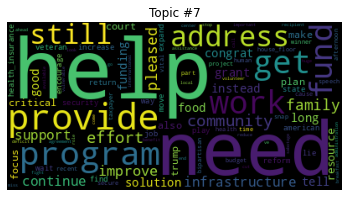

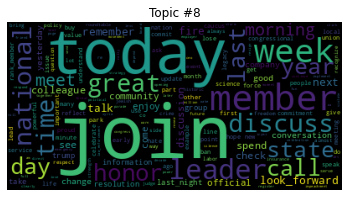

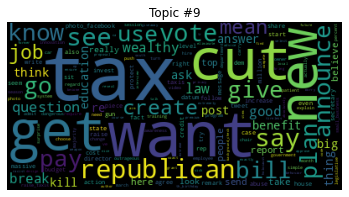

In [38]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

for t in range(lda_model_dem.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_model_dem.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

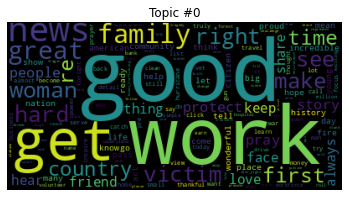

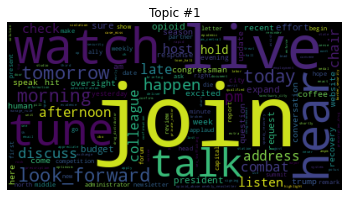

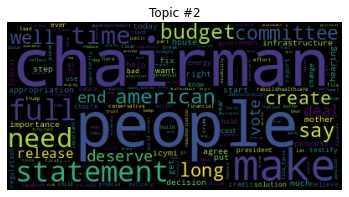

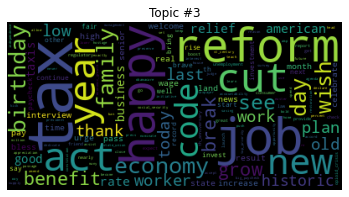

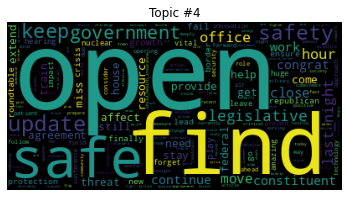

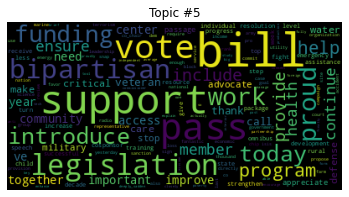

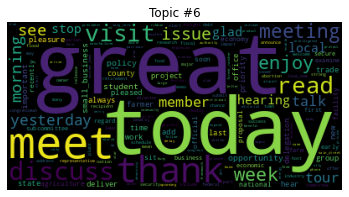

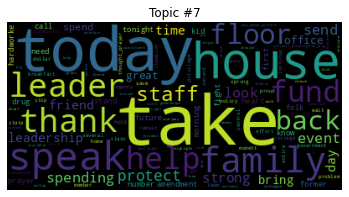

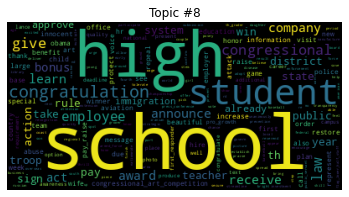

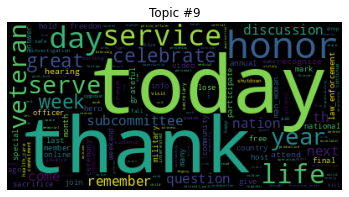

In [39]:
for t in range(lda_model_rep.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_model_rep.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()